## Imports

In [1]:
import sys, os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pprint import pprint

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.process_utils import merge_kernel_time, get_fc_flops

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
pd.set_option('display.max_rows', 80)
%matplotlib inline


## Create New Datasets + Examine Combined Dataframe

In [2]:
## Save
SAVE_DF = False
paths = ["merged_eval_times.csv", "merged_func_times.csv"]
eval_path, func_path = paths[0], paths[1]

if SAVE_DF:
    csv = ["eval.csv", "function.csv"]
    for c, f in zip(csv, paths):
        p = f"../data/linear/{c}"
        df = pd.read_csv(p)

        df['kFLOPs'] = df.apply(get_fc_flops, axis=1)
        print("Created kFlops")
        df = merge_kernel_time(df)
        # TODO: take care of this earlier.
        df['Precision'] = df['Precision'].astype(float).astype(int).astype(str)
        df.to_csv(f"../data/linear/{f}", index=False)
else:
    eval_df = pd.read_csv(f"../data/linear/{eval_path}")
    eval_df['Redo'] = "Eval"
    func_df = pd.read_csv(f"../data/linear/{func_path}")
    func_df['Redo'] = "Function"
    # small_df.info()

In [3]:
path = "../data/linear/merged_kernel_times.csv"
big_df = pd.read_csv(path)
big_df['Redo'] = "Base"
# big_df.info()

In [4]:
df = pd.concat([big_df, eval_df, func_df], axis=0)

In [5]:
df.head()

,Params,Inputs,Bias,Input Size,Output Size,Context,Stream,Device,CC,Avg. Active Threads Per Warp,...,Theoretical Occupancy (%),Threads (thread),Warp Cycles Per Executed Instruction (cycle),Warp Cycles Per Issued Instruction (cycle),Latency (ms),kFLOPs,Duration (usecond),Kernels Launched,Precision,Redo
0,1.161.0.1.1,1.0,0.0,1.0,1.0,1.0,7.0,0.0,8.0,14.22,...,18.75,128.0,20.52,17.92,0.109056,0.003,4.51,1.0,161,Base
1,1.161.0.1.120,1.0,0.0,1.0,120.0,1.0,7.0,0.0,8.0,30.27,...,100.00,1024.0,31.65,26.20,0.109568,0.360,3.84,1.0,161,Base
2,1.161.0.1.20,1.0,0.0,1.0,20.0,1.0,7.0,0.0,8.0,25.28,...,100.00,256.0,35.77,29.62,0.109056,0.060,3.78,1.0,161,Base
3,1.161.0.1.240,1.0,0.0,1.0,240.0,1.0,7.0,0.0,8.0,30.28,...,100.00,2048.0,34.27,28.37,0.107008,0.720,3.81,1.0,161,Base
4,1.161.0.1.4,1.0,0.0,1.0,4.0,1.0,7.0,0.0,8.0,17.36,...,100.00,256.0,35.53,29.43,0.108032,0.012,3.81,1.0,161,Base


In [11]:
categorical = ["Precision", "Redo"]
numeric = list(sorted(["Inputs", "Bias", "Input Size", "Output Size", "kFLOPs", "Kernels Launched"])) # TODO: Kernels Launched not available

X_cols = list(sorted(categorical + numeric))
y_cols = ['Latency (ms)', 'Duration (usecond)']

X, y = df[X_cols], df[y_cols]
new_df = pd.concat([X, y], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# train_df = pd.concat([X_train, y_train], axis=1)
# test_df = pd.concat([X_test, y_test], axis=1)

# train_df.info()

array([[<AxesSubplot:title={'center':'Bias'}>,
        <AxesSubplot:title={'center':'Input Size'}>,
        <AxesSubplot:title={'center':'Inputs'}>],
       [<AxesSubplot:title={'center':'Kernels Launched'}>,
        <AxesSubplot:title={'center':'Output Size'}>,
        <AxesSubplot:title={'center':'Precision'}>],
       [<AxesSubplot:title={'center':'kFLOPs'}>,
        <AxesSubplot:title={'center':'Latency (ms)'}>,
        <AxesSubplot:title={'center':'Duration (usecond)'}>]],
      dtype=object)

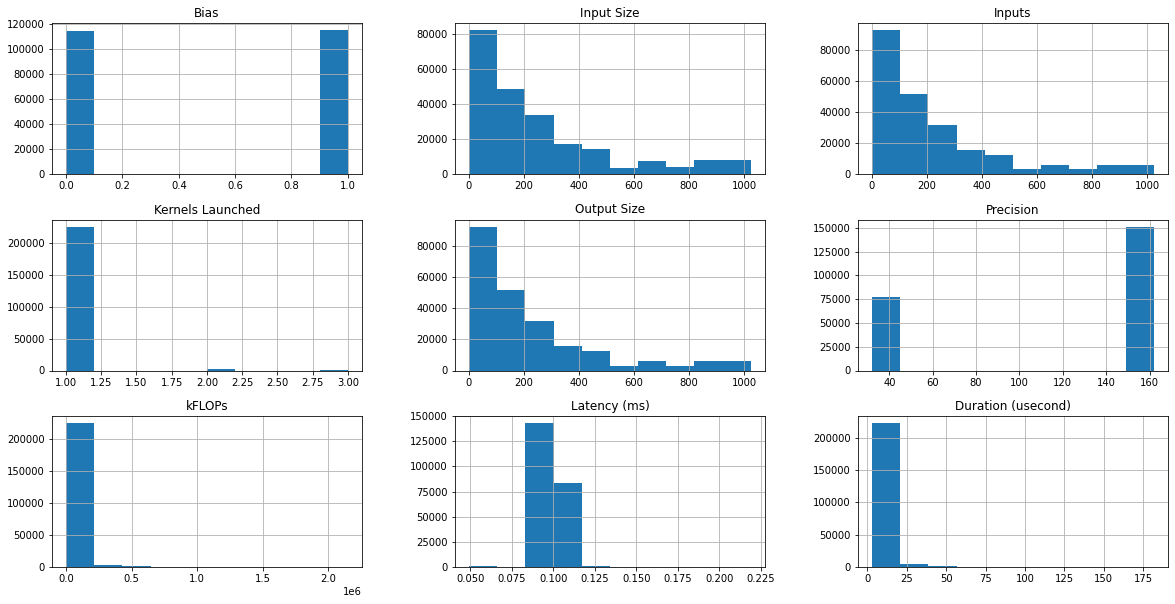

In [12]:
new_df.hist(figsize=(20, 10))

In [14]:
plt.figure(figsize=(20,10))
sns.heatmap(new_df[numeric + y_cols].corr(), annot=True)
plt.show()

In [19]:
def plot_scatter(df: pd.DataFrame, y: str):
    for col in df:
        if col != y:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=df[col], y=df[y])
            plt.show()

def plot_scatter_hues(df: pd.DataFrame, y: str, hue: str, palette: str = "bright", alpha=0.5) -> None:
    assert(y in df)
    assert(hue in df)
    for col in df:
        if col != y and col != hue:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=df[col], y=df[y], hue=df[hue], palette=palette, alpha=alpha)
            plt.show()

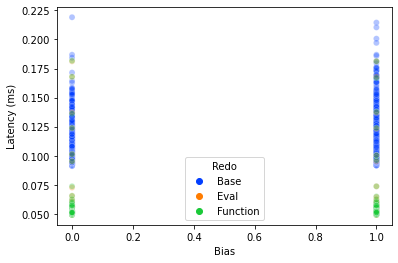

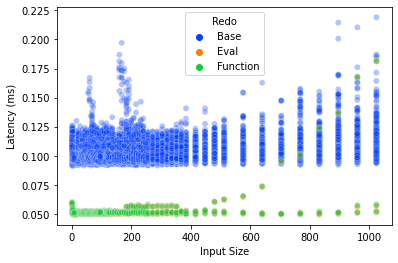

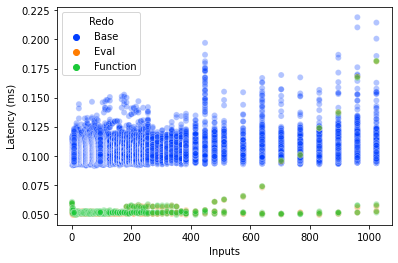

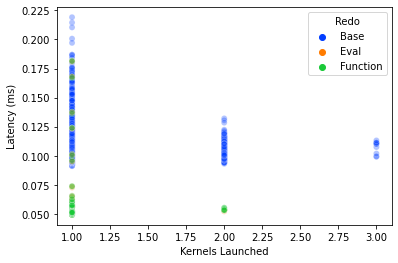

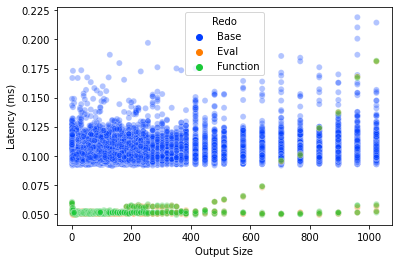

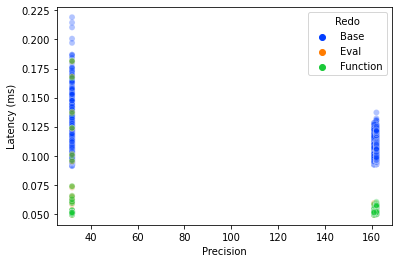

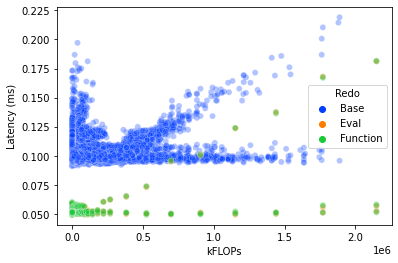

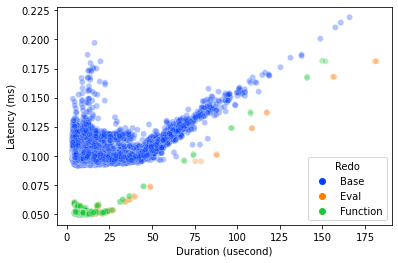

In [20]:
# plot_scatter(new_df, "Latency (ms)")
plot_scatter_hues(new_df, "Latency (ms)", "Redo", alpha=0.3)

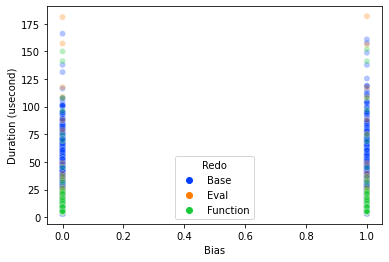

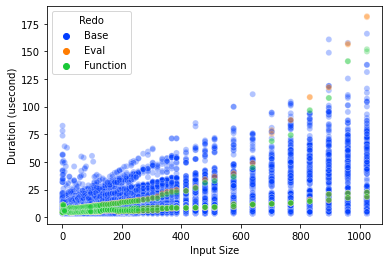

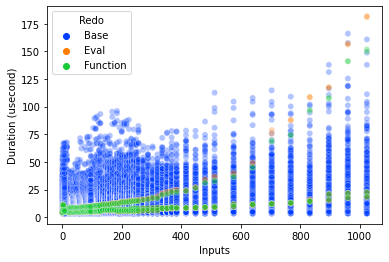

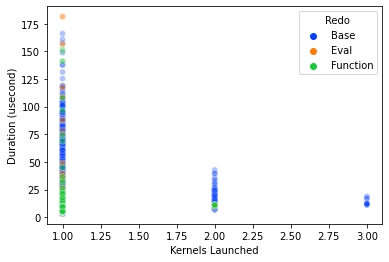

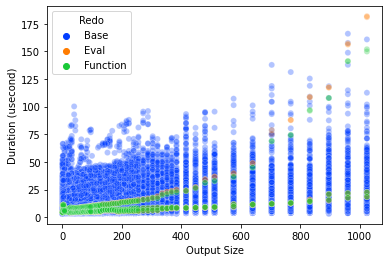

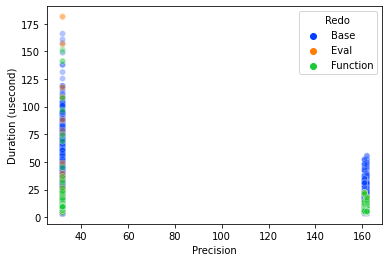

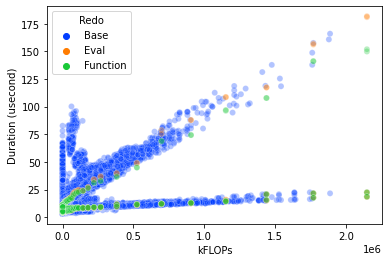

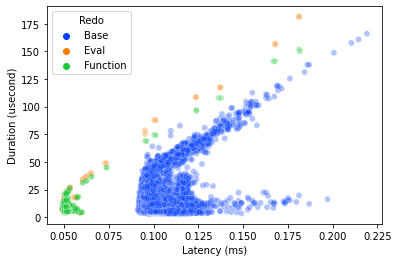

In [21]:
# plot_scatter(new_df, "Duration (usecond)")
plot_scatter_hues(new_df, "Duration (usecond)", "Redo", alpha=0.3)

## Outliers in original dataset

In [57]:
path = "../data/linear/merged_kernel_times.csv"
df = pd.read_csv(path)

categorical = ["Precision"]
numeric = list(sorted(["Inputs", "Bias", "Input Size", "Output Size", "kFLOPs", "Kernels Launched"])) # TODO: Kernels Launched not available

X_cols = list(sorted(categorical + numeric))
y_cols = ['Latency (ms)', 'Duration (usecond)']

X, y = df[X_cols], df[y_cols]
new_df = pd.concat([X, y], axis=1)

In [ ]:
# plot_scatter_hues(out_df)

In [58]:
# There are 78k different entries
# with kFLOPs < 0.25e6 and 0.11 > Latency > 0.10.
# instead of 
# kFLOPs < 0.25e6 and Latency > 0.10).

out_df = new_df[(new_df['kFLOPs'] < 0.25e6) & (new_df['Latency (ms)'] > 0.11)]

In [59]:
# 5011 entries
out_df.shape
# out_df.info()

(5011, 9)

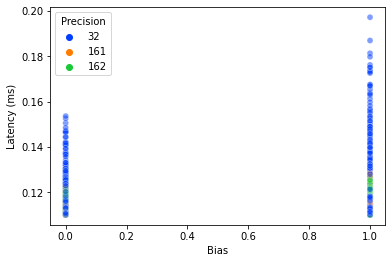

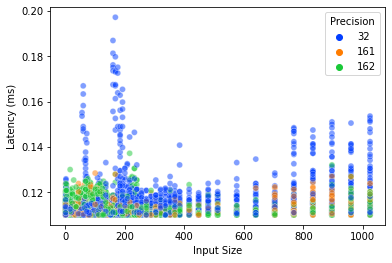

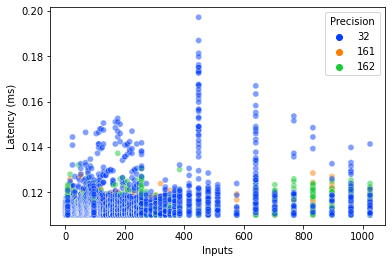

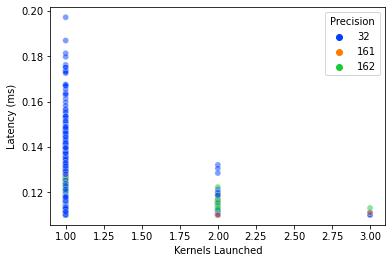

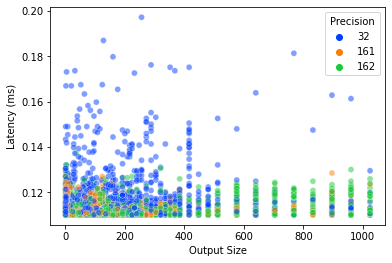

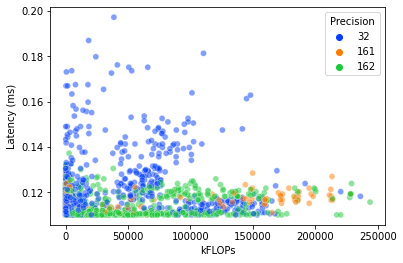

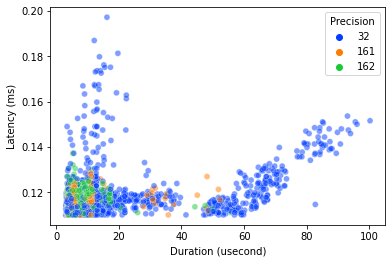

In [60]:
# plot_scatter(out_df, 'Latency (ms)')
plot_scatter_hues(out_df, 'Latency (ms)', 'Precision')

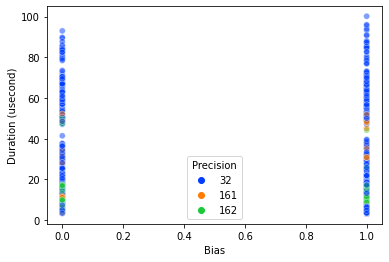

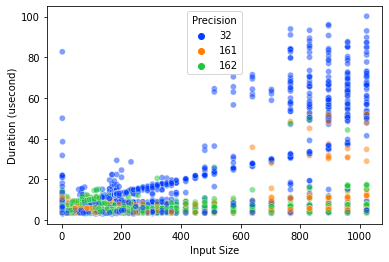

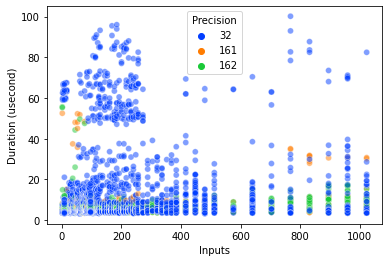

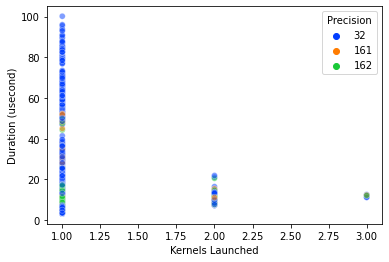

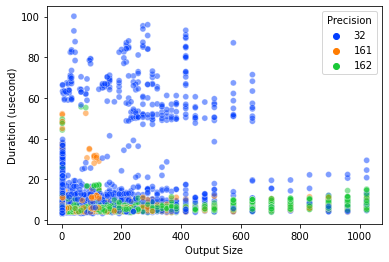

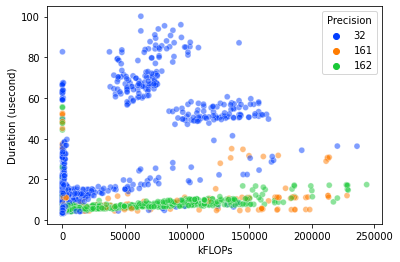

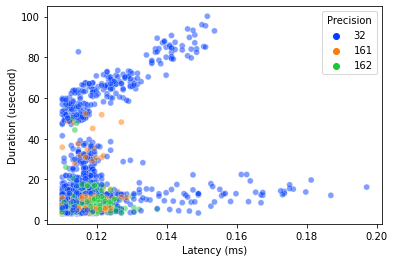

In [61]:
# plot_scatter(out_df, 'Latency (ms)')
plot_scatter_hues(out_df, 'Duration (usecond)', 'Precision')

array([[<AxesSubplot:title={'center':'Bias'}>,
        <AxesSubplot:title={'center':'Input Size'}>,
        <AxesSubplot:title={'center':'Inputs'}>],
       [<AxesSubplot:title={'center':'Kernels Launched'}>,
        <AxesSubplot:title={'center':'Output Size'}>,
        <AxesSubplot:title={'center':'Precision'}>],
       [<AxesSubplot:title={'center':'kFLOPs'}>,
        <AxesSubplot:title={'center':'Latency (ms)'}>,
        <AxesSubplot:title={'center':'Duration (usecond)'}>]],
      dtype=object)

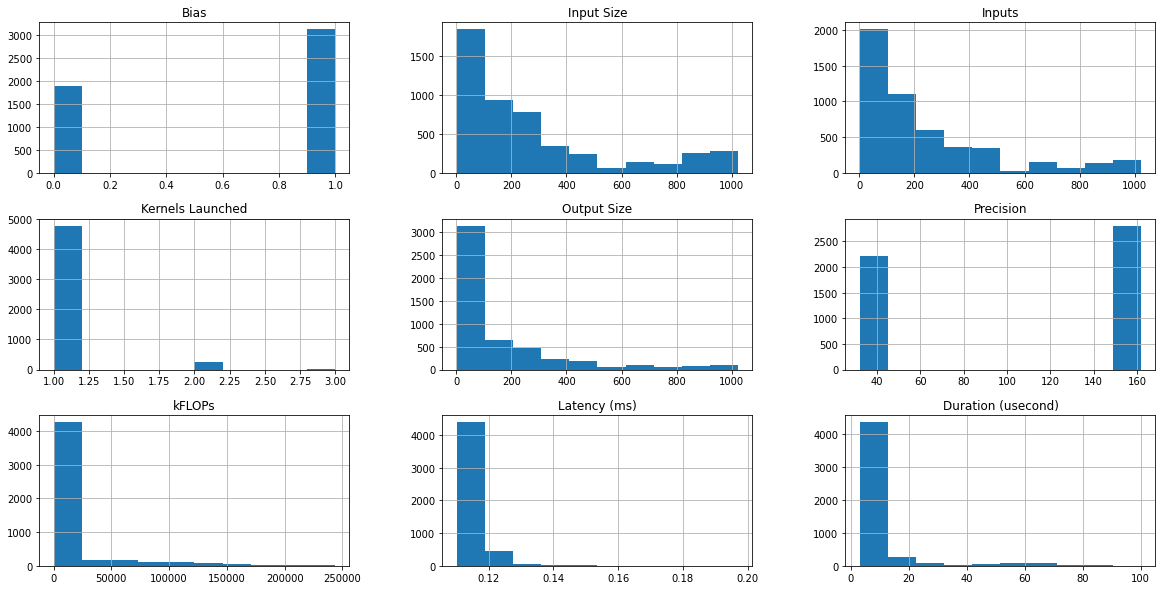

In [62]:
out_df.hist(figsize=(20, 10))

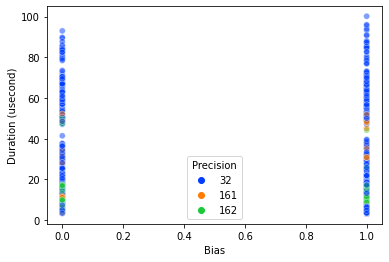

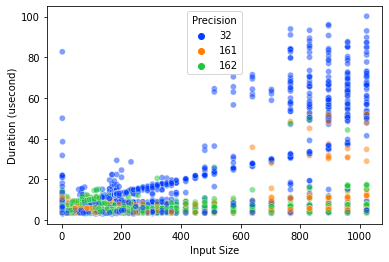

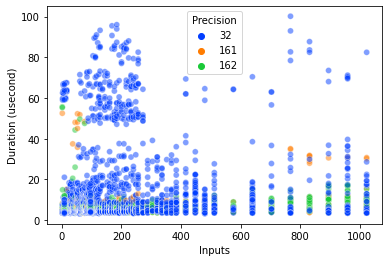

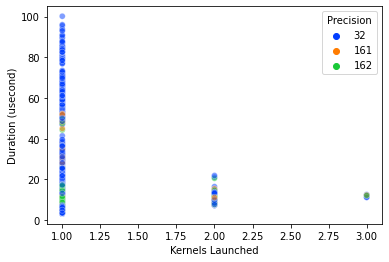

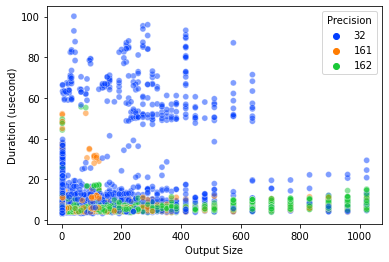

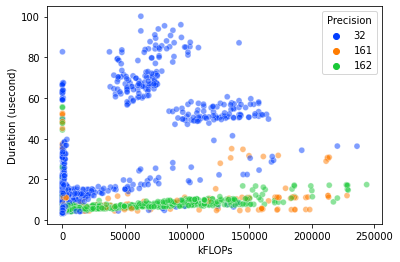

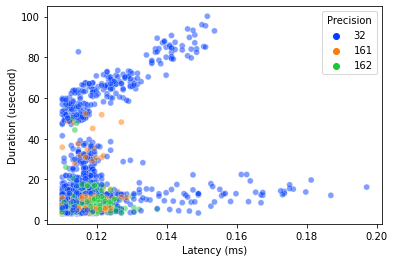

In [63]:
# plot_scatter(out_df, 'Duration (usecond)')
plot_scatter_hues(out_df, 'Duration (usecond)', 'Precision')

In [54]:
out_df_32 = out_df[out_df['Precision'] == 32]

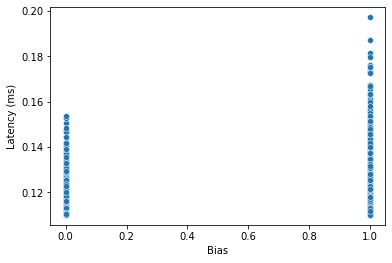

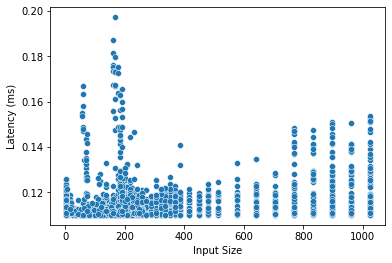

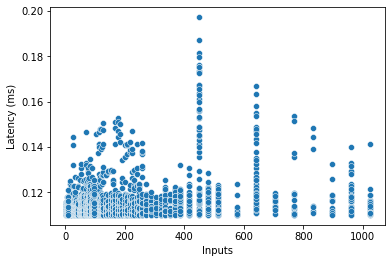

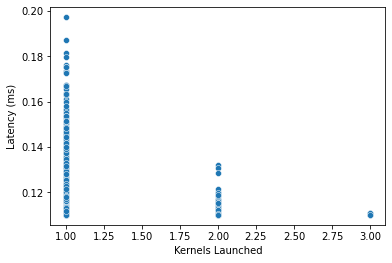

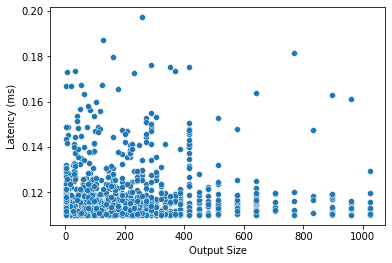

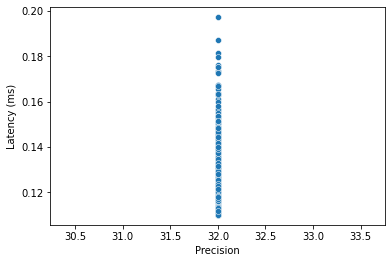

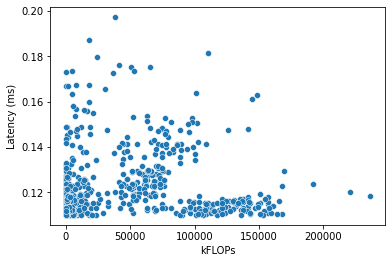

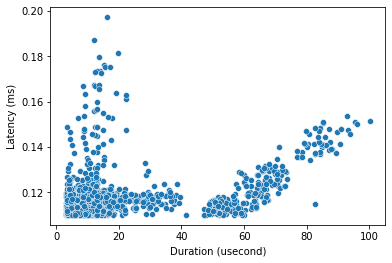

In [55]:
plot_scatter(out_df_32, 'Latency (ms)')

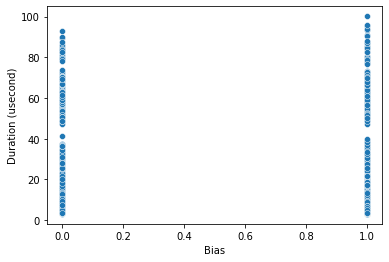

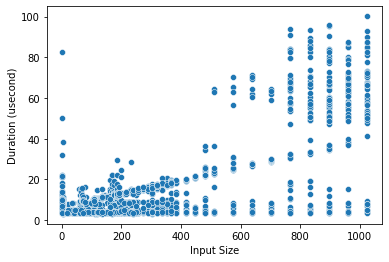

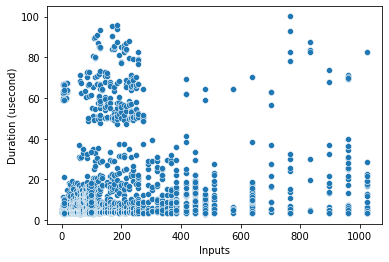

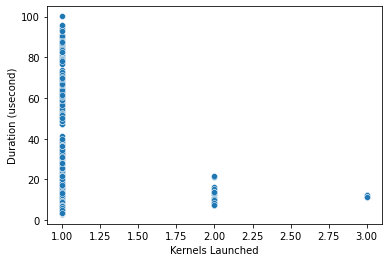

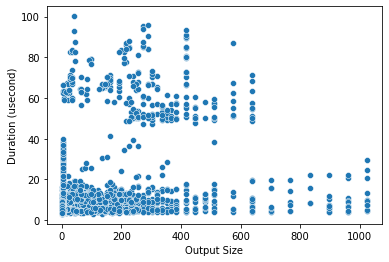

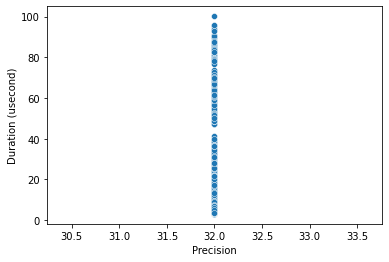

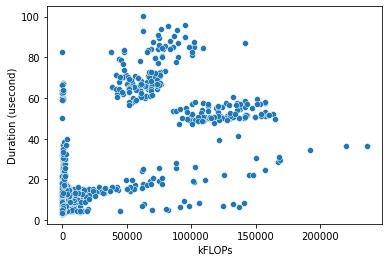

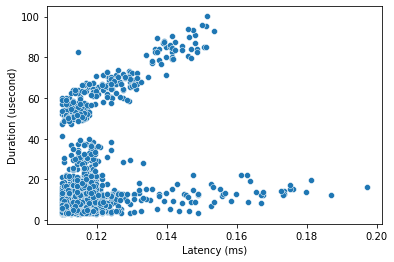

In [56]:
plot_scatter(out_df_32, 'Duration (usecond)')

In [45]:
out_df2 = out_df[(out_df['kFLOPs'] < 0.25e6) & (out_df['Latency (ms)'] > 0.13)]
out_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 9199 to 227884
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Bias                131 non-null    float64
 1   Input Size          131 non-null    float64
 2   Inputs              131 non-null    float64
 3   Kernels Launched    131 non-null    float64
 4   Output Size         131 non-null    float64
 5   Precision           131 non-null    int64  
 6   kFLOPs              131 non-null    float64
 7   Latency (ms)        131 non-null    float64
 8   Duration (usecond)  131 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 10.2 KB


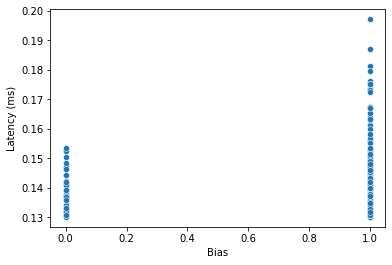

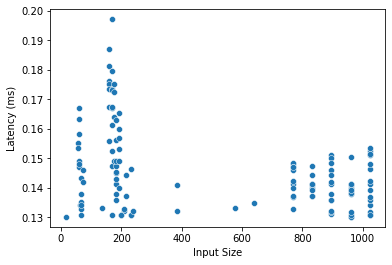

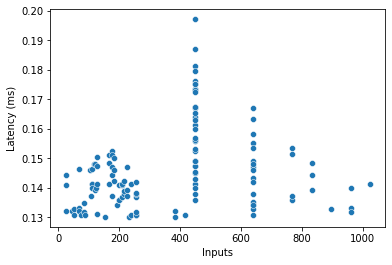

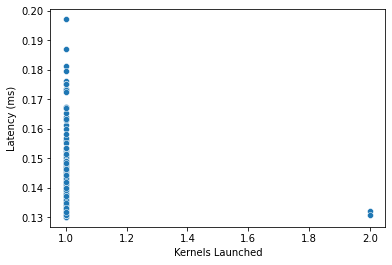

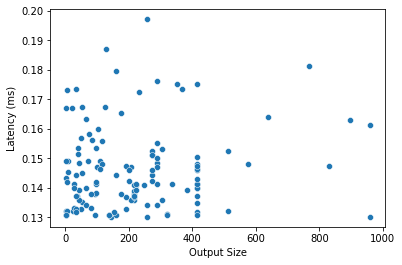

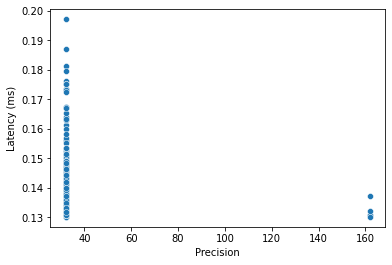

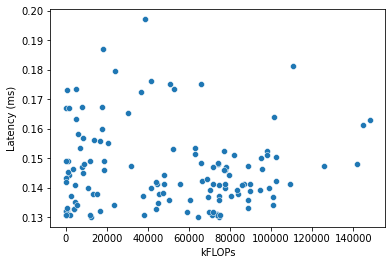

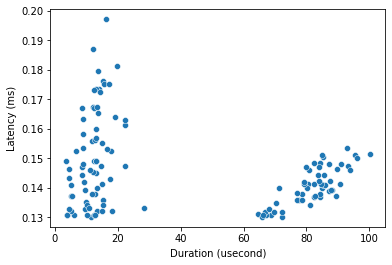

In [47]:
plot_scatter(out_df2, 'Latency (ms)')

In [51]:
out_df2[out_df2['Input Size'] > 500].shape

(63, 9)

In [46]:
# out_32_df = out_df[out_df['Precision'] == 32]
# # out_32_df.info()

In [43]:
# plot_scatter(out_32_df, 'Latency (ms)')

## Check New Values

In [45]:
new_df = pd.concat([eval_df, func_df], axis=0)
categorical = ["Precision"]
numeric = list(sorted(["Inputs", "Bias", "Input Size", "Output Size", "kFLOPs", "Kernels Launched", "Redo"])) # TODO: Kernels Launched not available

X_cols = list(sorted(categorical + numeric))
y_cols = ['Latency (ms)', 'Duration (usecond)']

X, y = new_df[X_cols], new_df[y_cols]
new_df = pd.concat([X, y], axis=1)

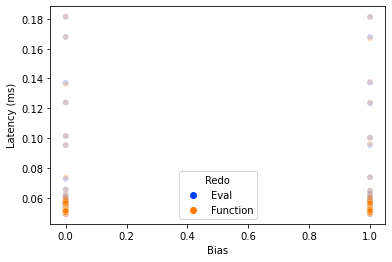

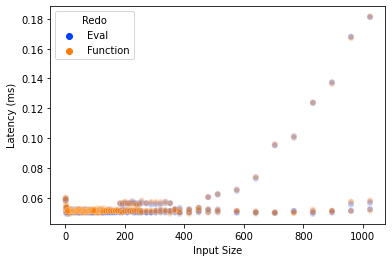

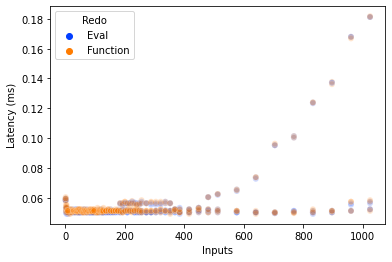

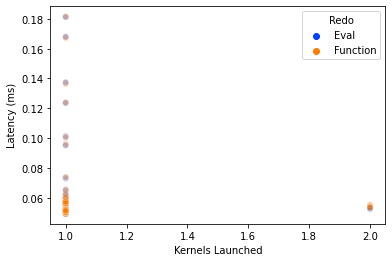

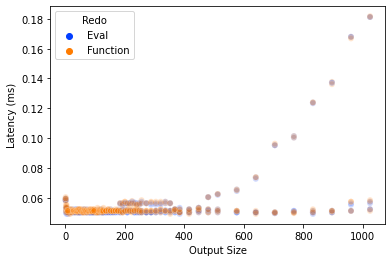

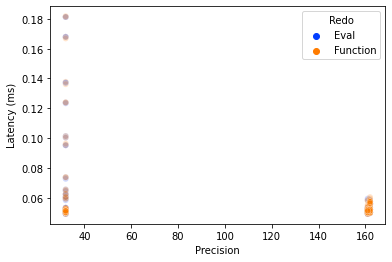

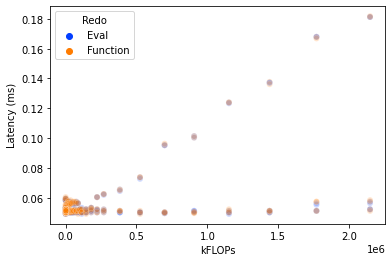

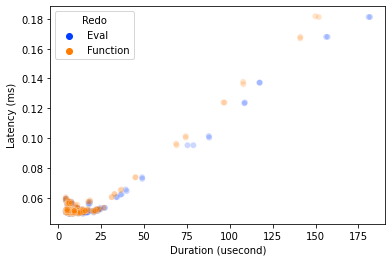

In [46]:
plot_scatter_hues(new_df, "Latency (ms)", "Redo", alpha=0.2)

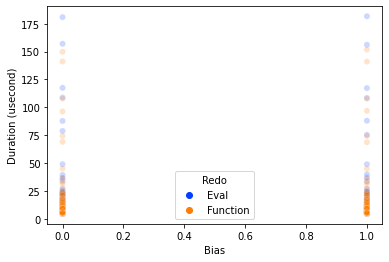

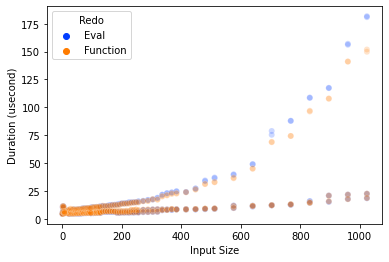

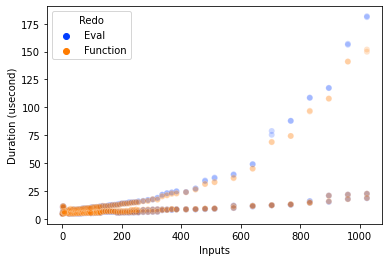

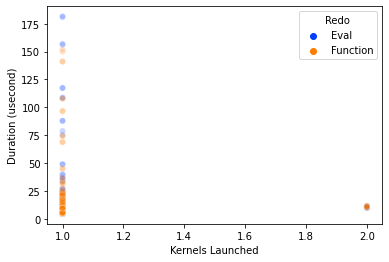

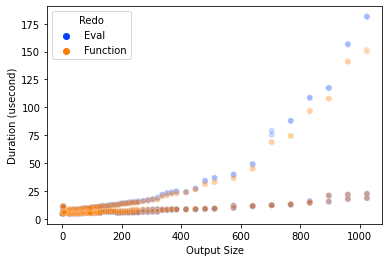

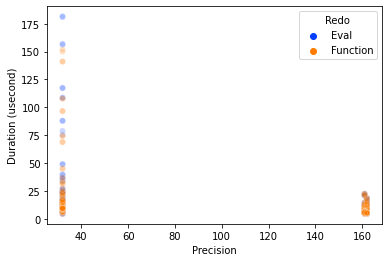

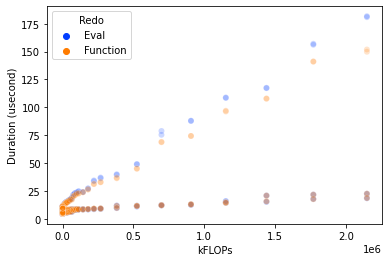

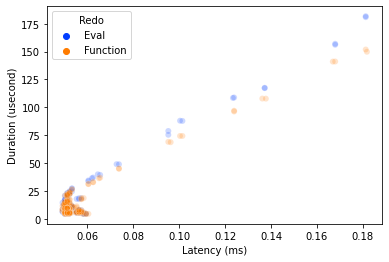

In [48]:
plot_scatter_hues(new_df, "Duration (usecond)", "Redo", alpha=0.2)

In [52]:
eval_data = eval_df[X_cols + y_cols]
func_data = func_df[X_cols + y_cols]

array([[<AxesSubplot:title={'center':'Bias'}>,
        <AxesSubplot:title={'center':'Input Size'}>,
        <AxesSubplot:title={'center':'Inputs'}>],
       [<AxesSubplot:title={'center':'Kernels Launched'}>,
        <AxesSubplot:title={'center':'Output Size'}>,
        <AxesSubplot:title={'center':'Precision'}>],
       [<AxesSubplot:title={'center':'kFLOPs'}>,
        <AxesSubplot:title={'center':'Latency (ms)'}>,
        <AxesSubplot:title={'center':'Duration (usecond)'}>]],
      dtype=object)

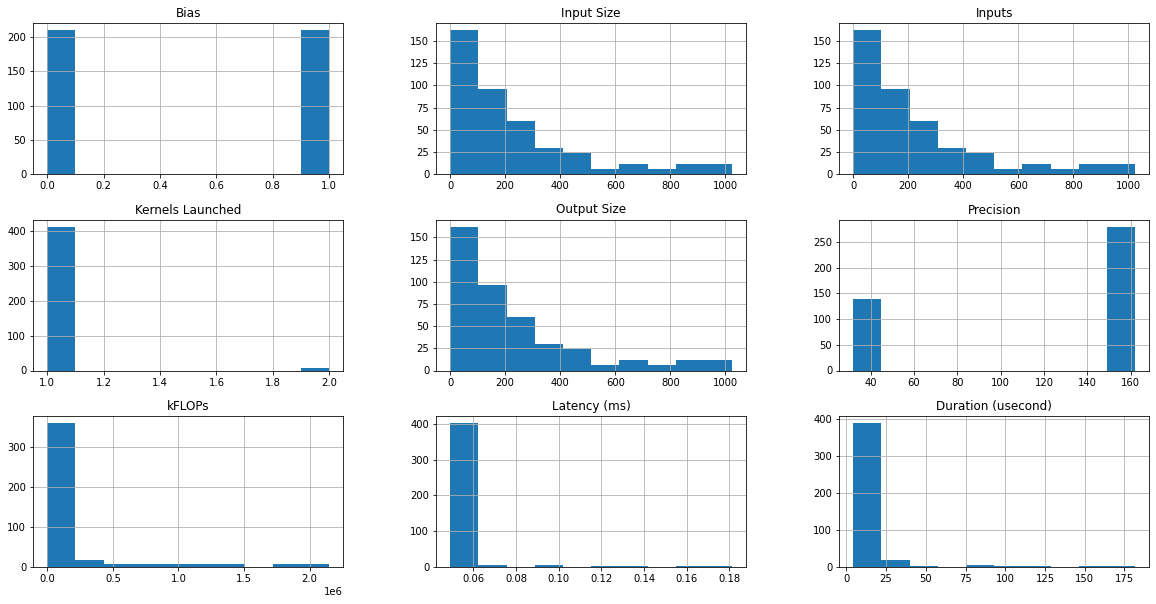

In [51]:
eval_data.hist(figsize=(20, 10))

array([[<AxesSubplot:title={'center':'Bias'}>,
        <AxesSubplot:title={'center':'Input Size'}>,
        <AxesSubplot:title={'center':'Inputs'}>],
       [<AxesSubplot:title={'center':'Kernels Launched'}>,
        <AxesSubplot:title={'center':'Output Size'}>,
        <AxesSubplot:title={'center':'Precision'}>],
       [<AxesSubplot:title={'center':'kFLOPs'}>,
        <AxesSubplot:title={'center':'Latency (ms)'}>,
        <AxesSubplot:title={'center':'Duration (usecond)'}>]],
      dtype=object)

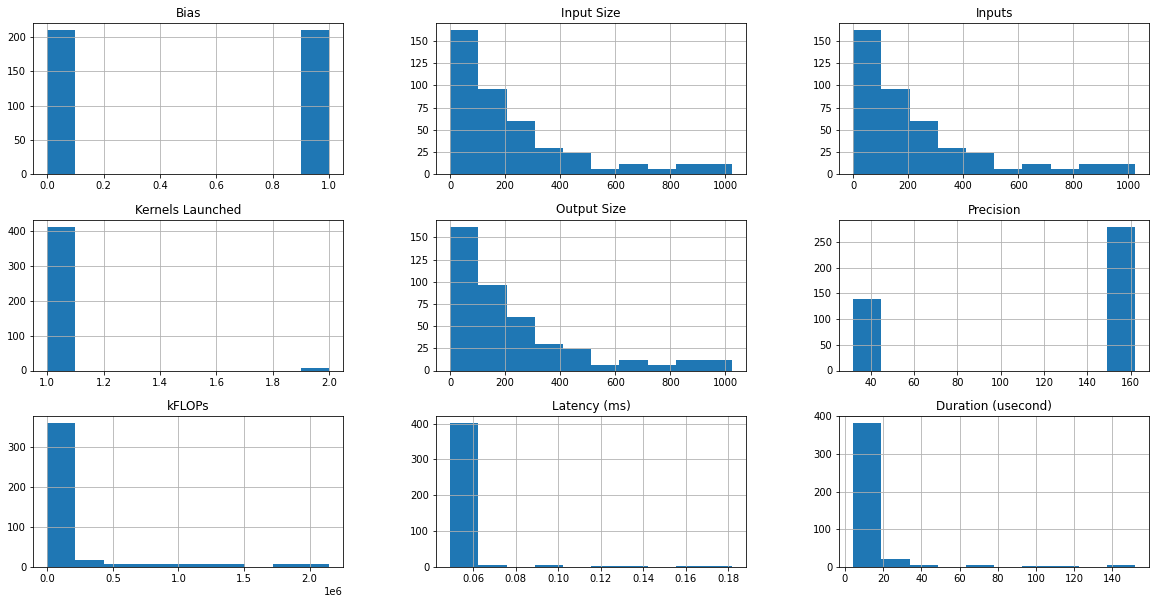

In [53]:
func_data.hist(figsize=(20, 10))